# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

In [2]:
import os
import pandas as pd
import torch 
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torchvision
from torchvision import transforms
import kagglehub
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, balanced_accuracy_score
# add additonal imports here
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir,column_class="articleTypeId", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg")  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

Download data with kagglehub

In [3]:
dataset_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
img_dir = os.path.join(dataset_path,"images")

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.

In [4]:
dataset = FashionDataset("dataset/train.csv",img_dir)

In [5]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


<class 'PIL.Image.Image'>


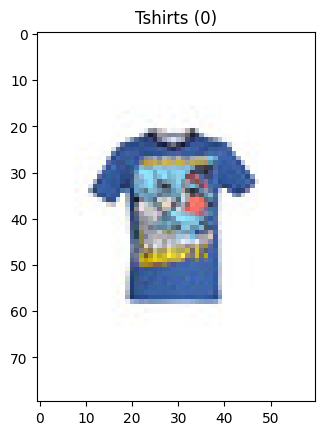

<class 'PIL.Image.Image'>


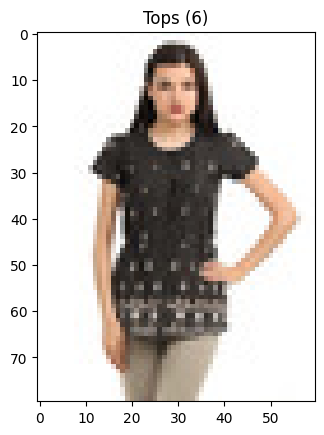

<class 'PIL.Image.Image'>


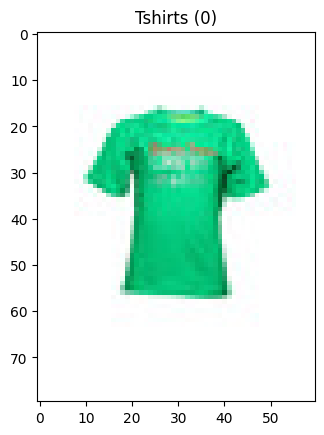

In [46]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset),3)

for i in random_indices:
    img, label = dataset[i]
    print(type(img))
    plt.title(dataset.df.iloc[i]["articleTypeName"]+f" ({label.item()})")
    plt.imshow(img)
    plt.show()

## Loading different datasets

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ResNet
    transforms.ToTensor(),          # Convert PIL Image to Tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize for RGB images
    # your image transformations 
]) 
train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)


label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)} 
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

## Task 1

In [12]:
# your solution
# train dataset: train_dataset
# test datset: main_test_dataset

train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dl = DataLoader(main_test_dataset, batch_size=64, shuffle=True)

model = torchvision.models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 39)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    
    model.train()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)

    print(f"Epoch [{epoch+1}/5], Loss: {running_loss/len(train_dl):.4f}, Accuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}")

Epoch [1/5], Loss: 0.8996, Accuracy: 0.7107, Balanced Accuracy: 0.5874
Epoch [2/5], Loss: 0.4941, Accuracy: 0.8277, Balanced Accuracy: 0.7502
Epoch [3/5], Loss: 0.4027, Accuracy: 0.8595, Balanced Accuracy: 0.7996
Epoch [4/5], Loss: 0.3436, Accuracy: 0.8790, Balanced Accuracy: 0.8279
Epoch [5/5], Loss: 0.2959, Accuracy: 0.8929, Balanced Accuracy: 0.8487
Epoch [6/5], Loss: 0.2571, Accuracy: 0.9066, Balanced Accuracy: 0.8721
Epoch [7/5], Loss: 0.2201, Accuracy: 0.9198, Balanced Accuracy: 0.8900
Epoch [8/5], Loss: 0.1829, Accuracy: 0.9337, Balanced Accuracy: 0.9101
Epoch [9/5], Loss: 0.1527, Accuracy: 0.9422, Balanced Accuracy: 0.9218
Epoch [10/5], Loss: 0.1156, Accuracy: 0.9578, Balanced Accuracy: 0.9429


In [13]:
# Evaluation phase on test set
model.eval()
test_preds = []
test_labels = []
test_loss = 0.0
with torch.no_grad():  # Disable gradient computation for test set
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
# Calculate test accuracy and balanced accuracy
test_acc = accuracy_score(test_labels, test_preds)
test_bal_acc = balanced_accuracy_score(test_labels, test_preds)
# Print statistics
print(f"Test Loss: {test_loss/len(test_dl):.4f}, Test Accuracy: {test_acc:.4f}, "
      f"Test Balanced Accuracy: {test_bal_acc:.4f}")

Test Loss: 0.4095, Test Accuracy: 0.8773, Test Balanced Accuracy: 0.8266


### Try a new data loader


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  # Normalize
])
train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)


label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)} 
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

In [23]:
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dl = DataLoader(main_test_dataset, batch_size=64, shuffle=True)

model = torchvision.models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 39)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    
    model.train()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)

    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(train_dl):.4f}, Accuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}")

Epoch [1/10], Loss: 0.9605, Accuracy: 0.6993, Balanced Accuracy: 0.5708
Epoch [2/10], Loss: 0.5305, Accuracy: 0.8208, Balanced Accuracy: 0.7394
Epoch [3/10], Loss: 0.4286, Accuracy: 0.8521, Balanced Accuracy: 0.7870
Epoch [4/10], Loss: 0.3611, Accuracy: 0.8724, Balanced Accuracy: 0.8186
Epoch [5/10], Loss: 0.3121, Accuracy: 0.8904, Balanced Accuracy: 0.8451
Epoch [6/10], Loss: 0.2745, Accuracy: 0.9018, Balanced Accuracy: 0.8628
Epoch [7/10], Loss: 0.2292, Accuracy: 0.9161, Balanced Accuracy: 0.8838
Epoch [8/10], Loss: 0.1930, Accuracy: 0.9294, Balanced Accuracy: 0.9041
Epoch [9/10], Loss: 0.1509, Accuracy: 0.9458, Balanced Accuracy: 0.9270
Epoch [10/10], Loss: 0.1267, Accuracy: 0.9534, Balanced Accuracy: 0.9360


In [24]:
# Evaluation phase on test set
model.eval()
test_preds = []
test_labels = []
test_loss = 0.0
with torch.no_grad():  # Disable gradient computation for test set
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
# Calculate test accuracy and balanced accuracy
test_acc = accuracy_score(test_labels, test_preds)
test_bal_acc = balanced_accuracy_score(test_labels, test_preds)
# Print statistics
print(f"Test Loss: {test_loss/len(test_dl):.4f}, Test Accuracy: {test_acc:.4f}, "
      f"Test Balanced Accuracy: {test_bal_acc:.4f}")

Test Loss: 0.4039, Test Accuracy: 0.8768, Test Balanced Accuracy: 0.8291


## Task 2

In [9]:
import os
import pandas as pd
import torch 
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from itertools import combinations
import tqdm
from tqdm import tqdm
from torch.utils.data.sampler import BatchSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# your solution
# train dataset: train_dataset
# test and support dataset: see scenarios table
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """
    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [29]:
train_dataset_sampler = BalancedBatchSampler(train_dataset.targets, n_classes=39, n_samples=3)
main_test_dataset_sampler = BalancedBatchSampler(main_test_dataset.targets, n_classes=39, n_samples=3)
new_test_dataset_sampler = BalancedBatchSampler(new_test_dataset.targets, n_classes=30, n_samples=3)
main_support_dataset_sampler = BalancedBatchSampler(main_support_dataset.targets, n_classes=39, n_samples=3)
new_support_dataset_sampler = BalancedBatchSampler(new_support_dataset.targets, n_classes=30, n_samples=3)
merged_test_dataset_sampler = BalancedBatchSampler(merged_test_dataset.targets, n_classes=69, n_samples=3)
merged_support_dataset_sampler = BalancedBatchSampler(merged_support_dataset.targets, n_classes=69, n_samples=3)

# check number of workers
triplets_train_dataset = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_dataset_sampler)
triplets_main_test_dataset = torch.utils.data.DataLoader(main_test_dataset, batch_sampler=main_test_dataset_sampler)
triplets_new_test_dataset = torch.utils.data.DataLoader(new_test_dataset, batch_sampler=new_test_dataset_sampler)
triplets_main_support_dataset = torch.utils.data.DataLoader(main_support_dataset, batch_sampler=main_support_dataset_sampler)
triplets_new_support_dataset = torch.utils.data.DataLoader(new_support_dataset, batch_sampler=new_support_dataset_sampler)
triplets_merged_test_dataset = torch.utils.data.DataLoader(merged_test_dataset, batch_sampler=merged_test_dataset_sampler)
triplets_merged_support_dataset = torch.utils.data.DataLoader(merged_support_dataset, batch_sampler=merged_support_dataset_sampler)

In [12]:
class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """
    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))

class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """
    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):
        triplets = self.triplet_selector.get_triplets(embeddings, target)
        if embeddings.is_cuda:
            triplets = triplets.to(embeddings.device)

        anchor_idx= triplets[:, 0]
        positive_idx= triplets[:, 1]
        negative_idx= triplets[:, 2]

        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)
        return losses.mean()

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.DataLoader,
                 validation_DataLoader: torch.utils.data.DataLoader ,
                 epochs: int
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs

    def run_trainer(self):
        for epoch in tqdm(range(self.epochs)):
            self.model.train() 
            train_losses=[]
            for batch in self.training_DataLoader:
                x,y=batch
                input, target = x.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                out = self.model(input)
                loss = self.criterion(out, target)

                loss_value = loss.item()
                #print(f"loss: {loss_value:.4f}", end=' ')
                train_losses.append(loss_value)

                loss.backward()
                self.optimizer.step()

            self.model.eval()
            valid_losses = []

            for batch in self.validation_DataLoader:
                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = resnet18(pretrained=False)
model.to(device)
triplet_selector = RandomTripletSelector()
criterion = TripletLoss(margin=1.0, triplet_selector=triplet_selector)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_loader = triplets_train_dataset
val_loader   = triplets_main_support_dataset

num_epochs = 30
trainer = Trainer(
    model=model,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    training_DataLoader=train_loader,
    validation_DataLoader=val_loader,
    epochs=num_epochs
)

'uncomment to run the trainer'
#trainer.run_trainer()

# Save the embedding weights
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/embedding_net.pth")
print("Training complete. Model saved to checkpoints/embedding_net.pth")

Using device: cpu


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training complete. Model saved to checkpoints/embedding_net.pth


In [15]:
checkpoint = torch.load('checkpoints/embedding_net.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Testing the model on different scenarios

In [32]:
def extract_embeddings(model, dataloader):
    embeddings = []
    labels = []
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            output = model(x)
            embeddings.append(output.cpu())
            labels.append(y.cpu())
    return torch.cat(embeddings), torch.cat(labels)

In [31]:

# scenario 1
embeddings1, labels1 = extract_embeddings(model, triplets_main_test_dataset)
embeddings2, labels2 = extract_embeddings(model, triplets_train_dataset)

# scenario 2
embeddings3, labels3 = extract_embeddings(model, triplets_main_test_dataset)
embeddings4, labels4 = extract_embeddings(model, triplets_main_support_dataset)

# scenario 3
embeddings5, labels5 = extract_embeddings(model, triplets_new_test_dataset)
embeddings6, labels6 = extract_embeddings(model, triplets_new_support_dataset)

# scenario 4
embeddings7, labels7 = extract_embeddings(model, triplets_merged_test_dataset)
embeddings8, labels8 = extract_embeddings(model, triplets_merged_support_dataset)

KeyboardInterrupt: 

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def evaluate_scenario(test_embeddings, test_labels, support_embeddings, support_labels):
    # Fit k-NN on the support set
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(support_embeddings, support_labels)

    # Predict on the test set
    preds = knn.predict(test_embeddings)

    # Compute accuracy
    acc = accuracy_score(test_labels, preds)
    return acc

# Scenario 1: Main test set with main support set
acc1 = evaluate_scenario(embeddings1, labels1, embeddings2, labels2)
print(f"Scenario 1 - Main Test Set with Main Support Set Accuracy: {acc1:.4f}")

# Scenario 2: Main test set with new support set
acc2 = evaluate_scenario(embeddings3, labels3, embeddings4, labels4)
print(f"Scenario 2 - Main Test Set with New Support Set Accuracy: {acc2:.4f}")

# Scenario 3: New test set with new support set
acc3 = evaluate_scenario(embeddings5, labels5, embeddings6, labels6)
print(f"Scenario 3 - New Test Set with New Support Set Accuracy: {acc3:.4f}")

# Scenario 4: Merged test set with merged support set
acc4 = evaluate_scenario(embeddings7, labels7, embeddings8, labels8)
print(f"Scenario 4 - Merged Test Set with Merged Support Set Accuracy: {acc4:.4f}")


NameError: name 'embeddings1' is not defined

## Task 3

In [ ]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset

In [ ]:
from scipy.spatial.distance import cdist

def average_precision(sorted_class_vals, true_class):
    ind = sorted_class_vals == true_class
    num_positive = ind.sum()
    cum_ind = np.cumsum(ind).astype(np.float32)
    enum = np.array(range(1, len(ind)+1)).astype(np.float32)
    return np.sum(cum_ind * ind / enum) / num_positive

# CHECK BETTER THIS PART
'lets say we use main classes support as a support dataset'
support_loader = triplets_main_support_dataset
test_loader = triplets_merged_test_dataset
support_embeddings, support_labels = extract_embeddings(model, support_loader)
test_embeddings, test_labels = extract_embeddings(model, test_loader)

distances=cdist(support_embeddings, support_embeddings)

test_labels=np.array(merged_test_dataset.targets)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].


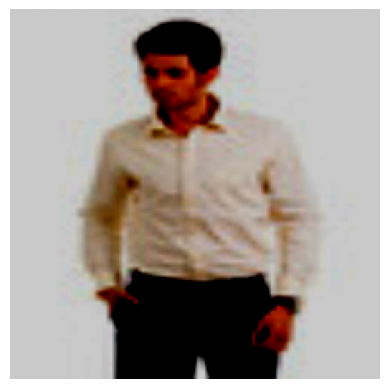

In [55]:

test_images = []
for i in range(len(merged_test_dataset)):
    sample = merged_test_dataset[i]
    image = sample[0]  # this should be a PIL image or a tensor
    if hasattr(image, 'permute'):  # it's likely a torch.Tensor
        image = image.permute(1, 2, 0).numpy()  # convert CHW to HWC
    test_images.append(image)
test_images = np.array(test_images)
# Display the first image
plt.imshow(test_images[0])
plt.axis("off")
plt.show()


In [ ]:
'''#for plotting if you want
for k in range(10):
    sorted_idx = list((np.argsort(distances[k,:])))
    sorted_idx = sorted_idx[1:]

    plt.subplot(1, 6, 1)
    plt.imshow(merged_test_dataset.data[k])
    for l in range(5):
      plt.subplot(1, 6, 2 + l)
      plt.imshow(test_images[sorted_idx[l]])
    plt.show()

    print("True class:")
    print(classes[test_labels[k]])
    print("Top 5 predicted:")
    print([classes[merged_test_dataset.targets[i]] for i in sorted_idx[:5]])
    print("Average precision {}".format(average_precision(test_labels[sorted_idx], test_labels[k])))
    print()'''

'#for plotting if you want\nfor k in range(10):\n    sorted_idx = list((np.argsort(distances[k,:])))\n    sorted_idx = sorted_idx[1:]\n\n    plt.subplot(1, 6, 1)\n    plt.imshow(merged_test_dataset.data[k])\n    for l in range(5):\n      plt.subplot(1, 6, 2 + l)\n      plt.imshow(test_images[sorted_idx[l]])\n    plt.show()\n\n\n    print("True class:")\n    print(classes[test_labels[k]])\n    print("Top 5 predicted:")\n    print([classes[merged_test_dataset.targets[i]] for i in sorted_idx[:5]])\n    print("Average precision {}".format(average_precision(test_labels[sorted_idx], test_labels[k])))\n    print()'

In [ ]:

def average_precision(sorted_class_vals, true_class):
    ind = sorted_class_vals == true_class
    print(ind)
    num_positive = ind.sum()
    print(num_positive)
    cum_ind = np.cumsum(ind).astype(np.float32)
    print(cum_ind)
    enum = np.array(range(1, len(ind)+1)).astype(np.float32)
    print(enum)
    print(np.sum(cum_ind * ind / enum) / num_positive)
    print()
    return np.sum(cum_ind * ind / enum) / num_positive

if hasattr(support_labels, "cpu"):
    support_labels = support_labels.cpu().numpy()
if hasattr(test_labels, "cpu"):
    test_labels = test_labels.cpu().numpy()

distances = cdist(test_embeddings, support_embeddings)   # shape (N_test, N_support)
N_test = 3
mAP = 0.0 # <— make sure to initialize

for k in range(N_test):
    sorted_idx = np.argsort(distances[k])
    mAP += average_precision(support_labels[sorted_idx], test_labels[k])
mAP /= N_test

print('mAP = {}'.format(mAP))

[False False False ... False False False]
51
[ 0.  0.  0. ... 51. 51. 51.]
[1.000e+00 2.000e+00 3.000e+00 ... 1.987e+03 1.988e+03 1.989e+03]
0.042541223413804

[False False False ... False False False]
51
[ 0.  0.  0. ... 51. 51. 51.]
[1.000e+00 2.000e+00 3.000e+00 ... 1.987e+03 1.988e+03 1.989e+03]
0.0421448034398696

[False False False ... False False False]
51
[ 0.  0.  0. ... 51. 51. 51.]
[1.000e+00 2.000e+00 3.000e+00 ... 1.987e+03 1.988e+03 1.989e+03]
0.037161981358247644

mAP = 0.04061600273730708


## Task 4

In [ ]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset